In [1]:
import os, zipfile
from collections import Counter
from zipfile import ZipFile
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, ADASYN

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from preprocessing import SelectMajorCategories, CycleEncoder
from visualizations import *
from language import *
import evaluation as ev

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [3]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [4]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

# Data Preparation:

In [5]:
target_col = 'rating'

In [6]:
x_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

x_test = df_test

In [7]:
# Data Fixing:
x_train['reviewer_birth_year'][x_train['reviewer_birth_year'] < 1850] = np.nan
x_test['reviewer_birth_year'][x_test['reviewer_birth_year'] < 1850] = np.nan

<ipython-input-7-17cb5da8b37f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['reviewer_birth_year'][x_train['reviewer_birth_year'] < 1850] = np.nan
<ipython-input-7-17cb5da8b37f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['reviewer_birth_year'][x_test['reviewer_birth_year'] < 1850] = np.nan


# Pre-processing

In [8]:
# Features Creation (review_title):
x_train['review_title_len_with_spaces'] = get_text_len(x_train['review_title'])
x_train['review_title_len_no_spaces'] = x_train['review_title'].apply(lambda x: len(x) - x.count(" "))
x_train['review_title_punct%'] = x_train['review_title'].apply(lambda x: count_punctuation(x))
x_test['review_title_len_with_spaces'] = get_text_len(x_test['review_title'])
x_test['review_title_len_no_spaces'] = x_test['review_title'].apply(lambda x: len(x) - x.count(" "))
x_test['review_title_punct%'] = x_test['review_title'].apply(lambda x: count_punctuation(x))

# Features Creation (review_text):
x_train['review_text_len_with_spaces'] = get_text_len(x_train['review_text'])
x_train['review_text_len_no_spaces'] = x_train['review_text'].apply(lambda x: len(x) - x.count(" "))
x_train['review_text_punct%'] = x_train['review_text'].apply(lambda x: count_punctuation(x))
x_test['review_text_len_with_spaces'] = get_text_len(x_test['review_text'])
x_test['review_text_len_no_spaces'] = x_test['review_text'].apply(lambda x: len(x) - x.count(" "))
x_test['review_text_punct%'] = x_test['review_text'].apply(lambda x: count_punctuation(x))

text_stats_features = ['review_title_len_with_spaces', 'review_title_len_no_spaces', 'review_title_punct%',
                       'review_text_len_with_spaces', 'review_text_len_no_spaces', 'review_text_punct%']


# submission_date features:
x_train['submission_date'] = [datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') for date_time_str in x_train['submission_date']]
x_train['submission_hour'] = [date_time.hour for date_time in x_train['submission_date']]
x_train['submission_weekday'] = [date_time.weekday() for date_time in x_train['submission_date']]
x_train['submission_month'] = [date_time.month for date_time in x_train['submission_date']]
x_train['submission_year'] = [date_time.year for date_time in x_train['submission_date']]
x_test['submission_date'] = [datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S') for date_time_str in x_test['submission_date']]
x_test['submission_hour'] = [date_time.hour for date_time in x_test['submission_date']]
x_test['submission_weekday'] = [date_time.weekday() for date_time in x_test['submission_date']]
x_test['submission_month'] = [date_time.month for date_time in x_test['submission_date']]
x_test['submission_year'] = [date_time.year for date_time in x_test['submission_date']]

# Encoding the cyclic time features:
c_enc = CycleEncoder(period=24)
submission_hour_cos_train, submission_hour_sin_train = c_enc.transform(x_train['submission_hour'].values)
x_train['submission_hour_cos'] = submission_hour_cos_train
x_train['submission_hour_sin'] = submission_hour_sin_train
submission_hour_cos_test, submission_hour_sin_test = c_enc.transform(x_test['submission_hour'].values)
x_test['submission_hour_cos'] = submission_hour_cos_test
x_test['submission_hour_sin'] = submission_hour_sin_test

c_enc = CycleEncoder(period=7)
submission_weekday_cos_train, submission_weekday_sin_train = c_enc.transform(x_train['submission_weekday'].values)
x_train['submission_weekday_cos'] = submission_weekday_cos_train
x_train['submission_weekday_sin'] = submission_weekday_sin_train
submission_weekday_cos_test, submission_weekday_sin_test = c_enc.transform(x_test['submission_weekday'].values)
x_test['submission_weekday_cos'] = submission_weekday_cos_test
x_test['submission_weekday_sin'] = submission_weekday_sin_test

time_cyclic_features = ['submission_hour_cos', 'submission_hour_sin', 'submission_weekday_cos', 'submission_weekday_sin']
time_sequence_features = ['submission_month']

In [9]:
# Selecting the major categories in the categorical features:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
sel = SelectMajorCategories(columns=cat_features, perc=0.01)
sel.fit(x_train)

x_train = sel.transform(x_train)
x_test = sel.transform(x_test)

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


In [10]:
# Preprocessing text features:
text_features = []
# review_title:
vect_review_title = TfidfVectorizer(analyzer=clean_text_stem, max_features=500)
x_train, x_test, vect_cols = vectorize_column(x_train, x_test, 'review_title',
                                               vect_review_title, vectorizer_name='tfidf')
text_features += vect_cols
# review_text:
vect_review_text = TfidfVectorizer(analyzer=clean_text_stem, max_features=1000)
x_train, x_test, vect_cols = vectorize_column(x_train, x_test, 'review_text',
                                               vect_review_text, vectorizer_name='tfidf')
text_features += vect_cols

In [11]:
# Encoding other columns:

# Features groups:
cat_features = [] + cat_features
num_float_features = ['reviewer_birth_year'] + text_stats_features + time_sequence_features
passthrough_features = [] + text_features + time_cyclic_features

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                                ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [12]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding),
                         ('feature selection var', VarianceThreshold(threshold=1e-3))])

In [13]:
x_train_encoded = preprocessor.fit_transform(x_train.loc[:, x_test.columns])
x_test_encoded = preprocessor.transform(x_test.loc[:, x_test.columns])

In [14]:
print('x_train_encoded:', x_train_encoded.shape)
print('x_test_encoded:', x_test_encoded.shape)

x_train_encoded: (92661, 561)
x_test_encoded: (39712, 561)


In [15]:
# Encoded data exploration:
x_train_encoded_df = pd.DataFrame(x_train_encoded)
df_desc = x_train_encoded_df.describe().transpose()
df_desc['variance'] = df_desc['std'] ** 2

df_desc.sort_values(by='std')

,count,mean,std,min,25%,50%,75%,max,variance
402,92661.0,0.003107,0.031628,0.000000,0.000000,0.000000e+00,0.000000e+00,0.720993,0.001000
437,92661.0,0.004139,0.031630,0.000000,0.000000,0.000000e+00,0.000000e+00,0.708626,0.001000
396,92661.0,0.002995,0.031633,0.000000,0.000000,0.000000e+00,0.000000e+00,0.613438,0.001001
487,92661.0,0.003135,0.031715,0.000000,0.000000,0.000000e+00,0.000000e+00,0.582752,0.001006
310,92661.0,0.003519,0.031727,0.000000,0.000000,0.000000e+00,0.000000e+00,0.807722,0.001007
...,...,...,...,...,...,...,...,...,...
2,92661.0,0.500761,0.500002,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000,0.250002
557,92661.0,-0.334501,0.517426,-1.000000,-0.707107,-5.000000e-01,6.123234e-17,1.000000,0.267730
560,92661.0,0.091161,0.680575,-0.974928,-0.433884,0.000000e+00,7.818315e-01,0.974928,0.463183
559,92661.0,-0.033905,0.726201,-0.900969,-0.900969,-2.225209e-01,6.234898e-01,1.000000,0.527368


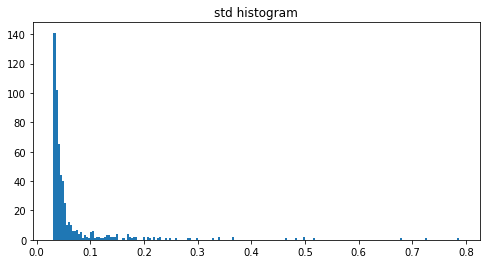

In [16]:
plt.figure(figsize=(8, 4))
plt.title('std histogram')
plt.hist(df_desc['std'], bins=200)
plt.show()

# Dealing with the imbalance:

In [17]:
print(sorted(Counter(y_train['rating']).items()))
x_train_encoded, y_train = SMOTE().fit_resample(x_train_encoded, y_train['rating'])
print(sorted(Counter(y_train).items()))

[(1, 19204), (2, 5935), (3, 11410), (4, 22574), (5, 33538)]
[(1, 33538), (2, 33538), (3, 33538), (4, 33538), (5, 33538)]


# Model Training

In [18]:
n_jobs = 4

In [19]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=16)
clf_rf.fit(x_train_encoded, y_train)
rf_metrics = pd.DataFrame(clf_rf.cv_results_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [20]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100, 800, 100)),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Create a based model
lrc = LogisticRegression()
# Instantiate the grid search model
clf_lrc = RandomizedSearchCV(estimator=lrc, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=8)
# clf_lrc = RandomizedSearchCV(estimator=lrc, param_distributions=param_grid,
#                              cv=5, n_jobs=n_jobs, verbose=2, n_iter=8, scoring='balanced_accuracy')
clf_lrc.fit(x_train_encoded, y_train)
lrc_metrics = pd.DataFrame(clf_lrc.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.63914366 0.640879   0.64084919 0.63582802 0.6107162
 0.64080148        nan]
  warnings.warn(
c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


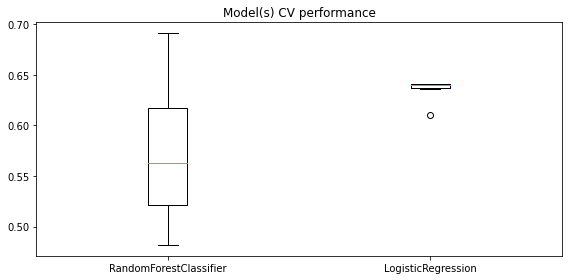

In [21]:
estimators_list = [clf_rf, clf_lrc]
plot_estimators_cvperf(estimators_list)

In [22]:
# Selecting the optimal model and Re-fiting with the whole training dataset:
estimators_cvperf = [pd.DataFrame(estimator.cv_results_)['mean_test_score'].max() for estimator in estimators_list]
clf_opt = estimators_list[np.argmax(estimators_cvperf)]
estimators_cvperf

[0.6913411652453934, 0.6408790029220587]

In [23]:
TARGET_NAMES = [x for x in np.unique(y_train.values)]
TARGET_DICT = {label:i for i,label in enumerate(TARGET_NAMES)}
TARGET_DICT

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

Classes evaluated: [1, 2, 3, 4, 5]
Correctly classified......: 148058/167690
Accuracy (simple) ........: 0.88
Balanced acc.  ...........: 0.88
Balanced acc. (adjusted)..: 0.85
Acc. norm (Recall avgs) ..: 0.88
Precision = tp / (tp + fp): [0.9  0.85 0.9  0.91 0.87] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.93 0.95 0.85 0.8  0.88] -> sensibility (true positive rate)
F1 score .................: [0.91 0.9  0.87 0.85 0.87] -> harmonic mean


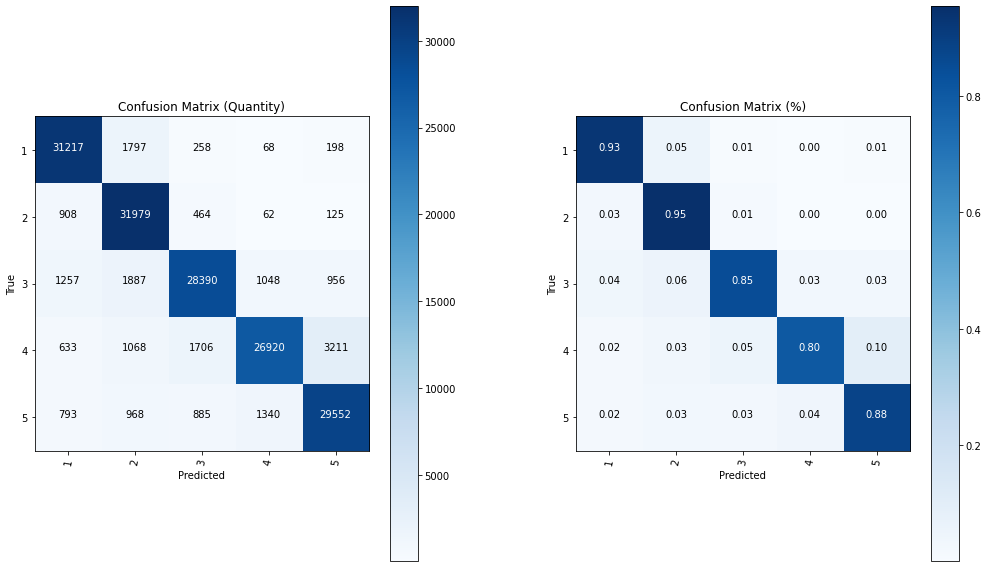

,accuracy,balanced_accuracy,balanced_accuracy adjusted,precision,recall,f1_score
0,0.88,0.88,0.85,0.90,0.93,0.91
1,0.88,0.88,0.85,0.85,0.95,0.90
2,0.88,0.88,0.85,0.90,0.85,0.87
3,0.88,0.88,0.85,0.91,0.80,0.85
4,0.88,0.88,0.85,0.87,0.88,0.87


In [24]:
y_true_train = [TARGET_DICT[x] for x in y_train.values]
y_pred_train = [TARGET_DICT[y] for y in clf_opt.best_estimator_.predict(x_train_encoded)]

results = ev.performance_measures(y_true_train, y_pred_train, TARGET_NAMES)
results = pd.DataFrame(results)
results

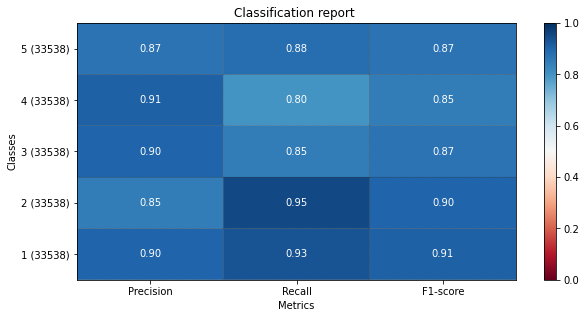

In [25]:
ev.plot_classification_report(classification_report(y_true_train, y_pred_train, target_names=[str(x) for x in TARGET_NAMES]))

In [26]:
model = clf_opt.best_estimator_.fit(x_train_encoded, y_train)
model

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=50)

# Submission

In [27]:
df_submission = pd.DataFrame({"id": [i for i in range(x_test_encoded.shape[0])],
                              "rating": model.predict(x_test_encoded)})
df_submission

,id,rating
0,0,4
1,1,2
2,2,3
3,3,2
4,4,1
...,...,...
39707,39707,1
39708,39708,4
39709,39709,2
39710,39710,5


In [28]:
submition_file = './submition_file.csv'
df_submission.to_csv(submition_file, index=False)

In [29]:
# !kaggle competitions list

In [30]:
!kaggle competitions submit -c i2a2-nlp-2021-sentiment-analysis -f submition_file.csv -m "Model 05: Mixed-features v3"

Successfully submitted to I2A2 2021 - Sentiment Analysis



  0%|          | 0.00/338k [00:00<?, ?B/s]
 31%|###       | 104k/338k [00:00<00:00, 998kB/s]
100%|##########| 338k/338k [00:02<00:00, 128kB/s]
